In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import cvxpy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)

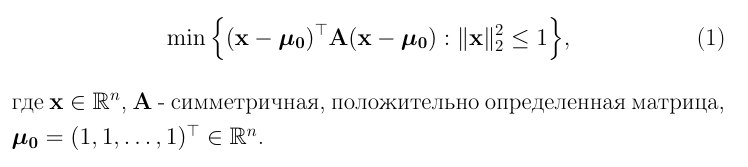

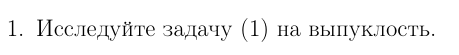

Функция $f(x)$ является квадратичной формой относительно $x$. 
Гессиан (вторая производная) этой функции $H(x) = 2A$. По условию матрица $A$ положительно определена, а значит и матрица $2A$ тоже положительно определена. Из этого следует, что функция $f(x)$ является выпуклой.

Ограничение можно записать как $g(x) = x^Tx \le 1$. Первая производная равна $2x$, а гессиан равен $2I$, где $I$ - единичная матрица. $2I$ положительно определена, а значит $g(x)$ - выпуклая функция. Из этого следует, что и ограничение $g(x) \le 1$ - выпуклое множество. Также можно сказать, что это это множество соответствует единичному шару в $\mathbb{R}^n$.

Таким образом, поскольку и функция цели, и множество ограничений выпуклы, оптимизационная задача является выпуклой.

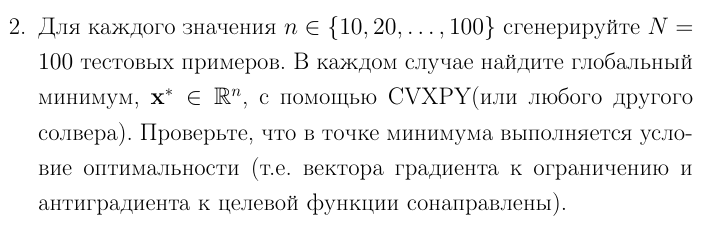

In [3]:
def solve_elipsoid(A, mu):

    x = cp.Variable(A.shape[0])

    objective = cp.Minimize(cp.quad_form(x - mu, A))

    constraints = [cp.norm2(x) <= 1]

    prob = cp.Problem(objective, constraints)

    result = prob.solve()

    return [x.value, result]

In [4]:
def solve_rand_elipsoids(
    n_dim: int = 2, n_samples: int = 100, random_states: list = None
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]

    cases = []

    for A in affine_ops:

        cases.append([A] + list(solve_elipsoid(A, mu)))

    return cases

In [5]:
def quadform_grad(A, x, mu):
    return (A + A.T) @ x - (A + A.T) @ mu

In [6]:
def constraint_grad(x):
    return 2 * x

In [7]:
def is_kkt_optimal(grad_obj, grad_constraint, eps=0.01):

    dot = np.dot(-grad_obj, grad_constraint)
    norm_f = np.linalg.norm(grad_obj)
    norm_g = np.linalg.norm(grad_constraint)
    if norm_f < eps or norm_g < eps:
        return True
    cos_angle = dot / (norm_f * norm_g)

    return bool((np.abs(cos_angle - 1) < eps).all())

In [8]:
ndims = range(10, 110, 10)

In [9]:
print("+---------------------------------------+")
for dim in ndims:
    mu = np.ones(dim)
    time_start = time.time()
    all_optim_flag = np.all(
            np.asarray(
                [
                    is_kkt_optimal(
                        quadform_grad(case[0], case[1], mu), constraint_grad(case[1])
                    )
                    for case in solve_rand_elipsoids(dim)
                ]
            )
        )
    time_total = (time.time()-time_start)

    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    print(
        f"| dim={dim_str} | {all_optim_flag} | avg_time: {time_total/100:.4f} sec |",
    )
print("+---------------------------------------+")

print("^_^")

+---------------------------------------+
| dim=10  | True | avg_time: 0.0031 sec |
| dim=20  | True | avg_time: 0.0033 sec |
| dim=30  | True | avg_time: 0.0038 sec |
| dim=40  | True | avg_time: 0.0042 sec |
| dim=50  | True | avg_time: 0.0055 sec |
| dim=60  | True | avg_time: 0.0061 sec |
| dim=70  | True | avg_time: 0.0072 sec |
| dim=80  | True | avg_time: 0.0085 sec |
| dim=90  | True | avg_time: 0.0658 sec |
| dim=100 | True | avg_time: 0.1027 sec |
+---------------------------------------+
^_^


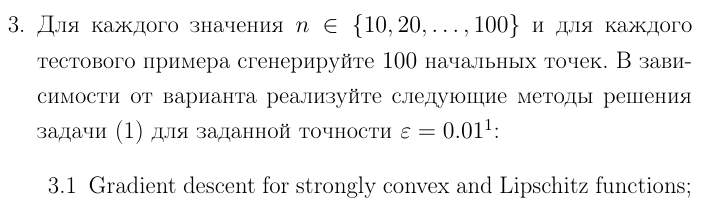

In [10]:
def project_to_constraint(x):
    x_norm = np.linalg.norm(x)
    return x if x_norm <= 1 else x / x_norm

def gradient_descent(A, mu, x_init, f_star, eps=0.01, max_iters=10000):
    
    alpha = np.min(np.linalg.eigvals(A*2))

    lr = 2 / alpha

    x = x_init.copy()
    iterations = 0

    while iterations < max_iters:

        grad = quadform_grad(A, x, mu)
        x_new = project_to_constraint(x - lr/(iterations+1) * grad)
        f_val = (x_new - mu).T @ A @ (x_new - mu)

        x = x_new
        iterations += 1

        if f_val - f_star <= eps:
            break

    return x_new, iterations, f_val

In [11]:
def gd_rand_elipsoids_avg_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    iters_total = 0
    time_total = 0

    for A in affine_ops:

        solution = solve_elipsoid(A, mu)

        case_time_start = time.time()

        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            iters_total += iters
            
        time_total += time.time() - case_time_start

    return time_total/(n_samples*n_init_states) , iters_total/(n_samples*n_init_states)

In [12]:
print("+-----------------------------------------------------+")
for dim in ndims:
    
    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    stat = gd_rand_elipsoids_avg_stats(dim)

    print(
        f"| dim={dim_str} | avg_iters: {stat[1]:.4f} | avg_time: {stat[0]:.4f} sec |",
    )
print("+-----------------------------------------------------+")

print("^_^")

+-----------------------------------------------------+
| dim=10  | avg_iters: 57.0442 | avg_time: 0.0004 sec |
| dim=20  | avg_iters: 172.6661 | avg_time: 0.0013 sec |
| dim=30  | avg_iters: 322.8161 | avg_time: 0.0027 sec |
| dim=40  | avg_iters: 391.2847 | avg_time: 0.0037 sec |
| dim=50  | avg_iters: 595.8917 | avg_time: 0.0068 sec |
| dim=60  | avg_iters: 952.1800 | avg_time: 0.0108 sec |
| dim=70  | avg_iters: 778.6082 | avg_time: 0.0125 sec |
| dim=80  | avg_iters: 1273.6822 | avg_time: 0.0230 sec |
| dim=90  | avg_iters: 1743.3404 | avg_time: 0.0359 sec |


KeyboardInterrupt: 

#5

In [13]:
def gd_rand_elipsoids_sol_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    cases = []

    for i, A in enumerate(affine_ops):

        solution = solve_elipsoid(A, mu)

        eig_vigals = np.sort(np.abs(np.linalg.eigvals(A)))
        conditional_number = eig_vigals[-1] / eig_vigals[0]


        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            cases.append({
                "example_id" : i,
                "conditional_number": conditional_number,
                "Lipsitz_L" : eig_vigals[-1],
                "strong_convexity_alpha": np.min(np.linalg.eigvals(2*A)),
                "is_kkt_optimal": is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt)),
                "solution_delta": np.abs(solution[-1] - f_val),
                "iters" : iters
            })

    return pd.DataFrame.from_records(cases)

In [14]:
dim_10_spectral_stats = gd_rand_elipsoids_sol_stats(10)

In [15]:
dim_10_spectral_stats

,example_id,conditional_number,Lipsitz_L,strong_convexity_alpha,is_kkt_optimal,solution_delta,iters
0,0,210.636509,10.527389,0.099958,True,0.005376,4
1,0,210.636509,10.527389,0.099958,True,0.004390,5
2,0,210.636509,10.527389,0.099958,True,0.003956,5
3,0,210.636509,10.527389,0.099958,True,0.008974,4
4,0,210.636509,10.527389,0.099958,True,0.005219,5
...,...,...,...,...,...,...,...
9995,99,76.219085,10.481893,0.275046,True,0.004429,9
9996,99,76.219085,10.481893,0.275046,True,0.008471,5
9997,99,76.219085,10.481893,0.275046,True,0.006358,8
9998,99,76.219085,10.481893,0.275046,True,0.004352,9


#5.2

In [29]:
example = dim_10_spectral_stats[dim_10_spectral_stats.example_id == 0]

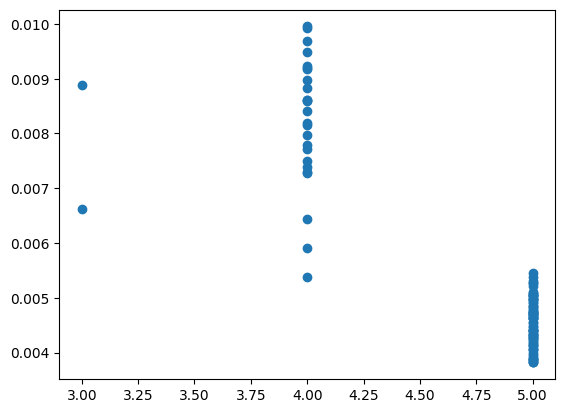

In [30]:
plt.scatter(example["iters"], example["solution_delta"])

In [18]:
dim_10_spectral_stats_agg = dim_10_spectral_stats.groupby("example_id").mean()

In [19]:
dim_10_spectral_stats_agg

,conditional_number,Lipsitz_L,strong_convexity_alpha,is_kkt_optimal,solution_delta,iters
example_id,,,,,,
0,210.636509,10.527389,0.099958,1.0,0.005538,4.71
1,199.767148,10.454247,0.104664,1.0,0.007473,79.00
2,110.884502,10.398736,0.187560,1.0,0.003706,2.00
3,145.131096,10.499169,0.144685,1.0,0.006741,24.76
4,73.129890,10.520779,0.287729,1.0,0.006305,9.49
...,...,...,...,...,...,...
95,285.361745,10.485875,0.073492,1.0,0.007860,78.00
96,546.401671,10.483503,0.038373,1.0,0.008518,250.00
97,322.158171,10.468885,0.064992,0.0,0.008744,203.00


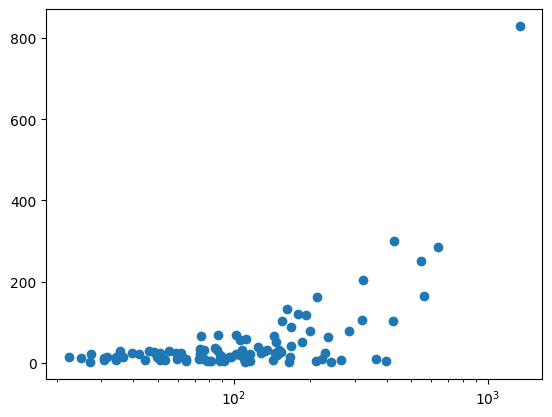

In [22]:
plt.xscale('log')
plt.scatter(dim_10_spectral_stats_agg["conditional_number"], dim_10_spectral_stats_agg["iters"])

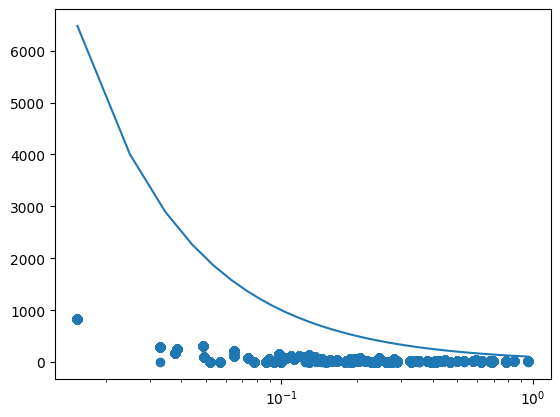

In [ ]:
plt.xscale('log')
plt.scatter(dim_10_spectral_stats["strong_convexity_alpha"], dim_10_spectral_stats["iters"])

mu_np_ls = np.linspace(dim_10_spectral_stats["strong_convexity_alpha"].min(),dim_10_spectral_stats["strong_convexity_alpha"].max(), 100)

hb_curve = 1 / (mu_np_ls*0.01)

plt.plot(mu_np_ls, hb_curve)